In [1]:
import torch
import torchgeometry as tgm
from torchgeometry.utils import inverse
import cv2
from torchgeometry.conversions import transform_points

In [2]:
# read the image with OpenCV
image = cv2.imread('./data/bennett_aden.png')[..., (2,1,0)]

img = tgm.image_to_tensor(image)
img = torch.unsqueeze(img.float(), dim=0)  # BxCxHxW

In [3]:
# get random 4 points                                  
_, c, h, w = img.shape  # channels, height, width
norm = torch.rand(1, 4, 2)

# the source points are the image vertexes
points_src = torch.FloatTensor([[
    [80, 30], [170, 30], [170, 120], [80, 120],
    #[0, 0], [w - 1, 0], [w - 1, h - 1], [0, h - 1],
]])

# get a random destination box
#points_dst = points_src + norm
points_dst = torch.FloatTensor([[
    [0, 0], [31, 0], [31, 31], [0, 31],
]])

#points_dst = torch.FloatTensor([[
#    [0, 0], [110, 0], [110, 90], [0, 90],
#]])
                                                
# compute perspective transform
origin_mat_center = torch.unsqueeze(
    torch.eye(
        3),
    dim=0)
origin_mat_center[..., 0, 2] = -float(w) / 2
origin_mat_center[..., 1, 2] = -float(h) / 2

pts_center = transform_points(origin_mat_center, points_src)

normal_trans_pix = torch.tensor([[
        [2. / (w), 0., -1.],
        [0., 2. / (h), -1.],
        [0., 0., 1.]]])

pix_trans_normal = inverse(normal_trans_pix)

H_cv2 = cv2.getPerspectiveTransform(points_src[0].numpy(), points_dst[0].numpy())

print('image shape', image.shape)
image_warp_cv = cv2.warpPerspective(image, H_cv2, dsize=(64, 64))
print('image warp cv shape', image_warp_cv.shape)

H_tgm = tgm.get_perspective_transform(points_src, points_dst)

print("Error: ", (H_tgm[0].numpy()-H_cv2).sum())

# warp the original image by the found homography
img_warp = tgm.warp_perspective(img, H_tgm, dsize=(64,64)) #dsize conventions are reverse of OpenCV, and if we want to generate the same output as OpenCV, we have to keep dsize = original image size so that no resizing happens

# convert back to numpy
image_warp = tgm.tensor_to_image(img_warp.byte())

# draw points into original image
for i in range(4):
    center = tuple(points_src[0, i].long().numpy())
    image = cv2.circle(image.copy(), center, 3, (0, 255, 0), -1)

image shape (200, 250, 3)
image warp cv shape (64, 64, 3)
Error:  3.392016667934459e-06


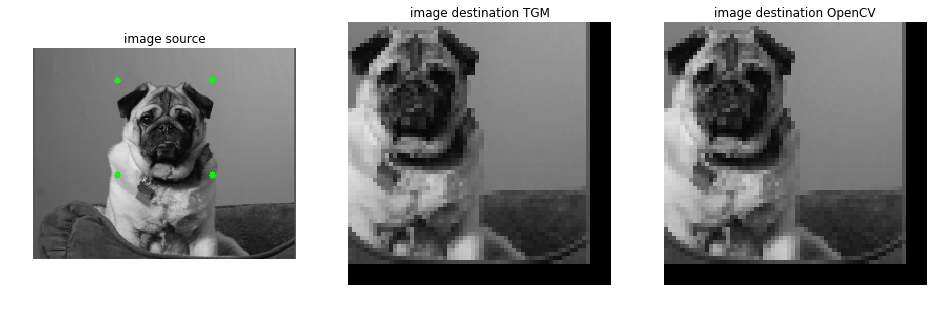

In [4]:
import matplotlib.pyplot as plt 
%matplotlib inline

# create the plot
fig, axs = plt.subplots(1, 3, figsize=(16, 10))
axs = axs.ravel()

axs[0].axis('off')
axs[0].set_title('image source')
axs[0].imshow(image)

axs[1].axis('off')
axs[1].set_title('image destination TGM')
axs[1].imshow(image_warp[0:90,0:110,:])   #now we display only same part of image as OpenCv dsize

axs[2].axis('off')
axs[2].set_title('image destination OpenCV')
axs[2].imshow(image_warp_cv)